# Preliminaries
In this first part we simply import all the libraries necessary to correctly run the whole project, we initialize GeDiM4Py and the geometry parameters for the mesh.

### Import libraries

In [1]:
!pip install pandas

import sys, time
sys.path.append('/content/CppToPython')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import GeDiM4Py as gedim

### Initialize GeDiM4Py

In [3]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = {'GeometricTolerance': 1.0e-8}

gedim.Initialize(config, lib)

### Set geometry parameters

In [4]:
meshSize = 0.001
order = 1

# Boundary conditions are all Homogenous Dirichlet BCs, we use only one marker (= 1) for the border
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
# Order=order -> Order of finite element
# BoundaryConditionsType=2 -> Dirichlet BCs
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotMesh(mesh)

# Nonlinear Elliptic Problem: POD vs PINNs and POD-nn

Aim of the project is to solve the following parametrized problem on the bidimensional spatial domain
\begin{equation*}
    \bar{\Omega} = [0, 1] \times [0, 1]
\end{equation*}
Given
\begin{equation*}
    \mathbf{\mu}=(\mu_0, \mu_1)\in\mathcal{P}=[0.1,1]\times[0.1,1]
\end{equation*}
find $u(\mathbf{\mu})$ such that
$$
\begin{cases}
\displaystyle - \Delta u(\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) = g(\mathbf{x};\mathbf{\mu}) & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω
\end{cases}
$$
Source term is defined as
\begin{equation*}
    g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
\end{equation*} 

## Weak Formulation
The weak formulation of the problem reads: find $u \in V := H^1_0(\Omega)$ such that
\begin{equation*}
    \int_{\Omega} \nabla u\cdot\nabla v + \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v - \int_{\Omega} g\, v = 0 \quad \forall v \in V
\end{equation*}
We can rearange this formulation as
\begin{equation*}
    f(u; v) := f_1(u; v) + f_2(u; v) + f_3(u; v) = 0 \quad \forall v \in V
\end{equation*}
having
$$
\begin{align*}
    f_1(u; v) &= \int_{\Omega} \nabla u\cdot\nabla v \\
    f_2(u; v) &= \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v \\
    f_3(u; v) &= - \int_{\Omega} g\, v
\end{align*}
$$

## Newton Schema
Since $f(u; v)$ is non-linear with respect to $\mu$, we are not able to separate variables, however we can implement the Newton schema in order to solve, for each iteration $k$, the following problem
\begin{equation*}
    J_f [\partial u]_{|_{u_k}} \partial u = - f(u_k; v) = 0 \quad \forall v \in V
\end{equation*}
having $J_f [\partial u]_{|_{u_k}}$ to be the evaluation of the Jacobian of $J_f$ in the point $u_k$ along the direction $\partial u$.

Both functions $f_1(u; v)$ and $f_3(u; v)$ are linear in $u$, this implies that their Gateux derivatives are respectively
$$
\begin{align*}
    J_{f_1} [\partial u]_{|_{u_k}} &= f_1(u; v)=\int_{\Omega} \nabla \partial u \cdot \nabla v \\
    \qquad J_{f_3} [\partial u]_{|_{u_k}} &= 0 
\end{align*}
$$
On the other hand $f_3(u; v)$ is non-linear in u, and its Gateaux derivative is given by
\begin{align*}
    J_{f_2} [\partial u]_{|_{u_k}}&=\lim_{h\to0}\frac{f_2(u_k+\partial u\, h)-f(u_k)}{h}=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} \left(e^{\mu_1\,(u_k+\partial u\, h)}-1\right) v-\int_{\Omega} \left(e^{\mu_1\,u_k}-1\right) v=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} e^{\mu_1\,u_k}\left(e^{\mu_1\,\partial u\, h}-1\right) v=\\
    \\
    &=\mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v 
\end{align*}
which is a reaction term.

After some computations we are hable to write down the linear system which needs to be solved in each iteration $k$: fixed $u_k$, find $\partial u$ such that
$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v  = - \int_{\Omega} \underline{\nabla u_k}_{g_1} \cdot \nabla v - \frac{\mu_0}{\mu_1} \int_{\Omega} \underline{\left(e^{\mu_1\,u_k}-1\right)}_{g_2} v + \int_{\Omega} g\, v 
$$
On the left hand side we have the classical diffusion, reaction and advection terms. On the other hand, on the right hand side we have function $f(u; v)$ evaluated in $u_k$.

# 1. A benchmark problem: POD method for the Full Order Model
Firstly we solve the Nonlinear Elliptic problem by means of POD-Galerkin method over a Finite Element full order model by choosing the exact solution
\begin{equation*}
   u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)
\end{equation*}
and computing the respective right hand side define as
$$
\begin{align*}
   g_{ex}(\mathbf{x};\mathbf{\mu}) &= -\Delta u_{ex}(\mathbf{x};\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) \\
   &= 32x_0(1-x_0) + 32x_1(1-x_1) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
\end{align*}
$$

Then we will apply our code to the problem introduced above.

### $\mu$ parameters definition

In [ ]:
mu = [0.8, 0.4]

### Matrices construction functions
From now on we indicate as numPoints the quadrature points used to evaluate the basis functions

In [6]:
# Let's start by defyning the coefficient of the Stiffness Matrix
def diffusion(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

# Let's move on by defyning all the functions for Reaction Matrix
# Reaction coefficient
def reaction(numPoints, points):
	return (mu[0] * np.ones(numPoints, order='F')).ctypes.data

# Coefficient depending on u_k
def reactionNonLinear(numPoints, points, u, uX, uY):
	# u evaluated in the quadrature points
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	nonlinearValues = np.exp(mu[1] * vecu)
	return nonlinearValues.ctypes.data

# Right hand side g_ex computed so that u(x0, x1) = 16*x0*x1*(1-x0)*(1-x1) woul be the exact solution of the nonlinear elliptic problem
def rhsExactG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactGValues = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + mu[0] / mu[1] * (np.exp(mu[1] * 16 * matPoints[0,:] * matPoints[1,:] * (1.0 - matPoints[0,:]) * (1.0 - matPoints[1,:])) - 1)
	return exactGValues.ctypes.data

# Right hand side g given from the problem
def rhsG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	gValues = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
	return gValues.ctypes.data

# Nonlinear term evaluated in u_k
def rhsNonlinearG2(numPoints, points, u, uX, uY):
	vecu = gedim.make_nd_array(u, numPoints, np.double) #evaluation of u in quadrature points of our cell
	valuesNl = mu[0] / mu[1] * (np.exp(mu[1] * vecu) - 1)
	return valuesNl.ctypes.data

# Diffusion term evaluated in u_k
def rhsNonlinearG1(numPoints, points, u, uX, uY):
	vecuX = gedim.make_nd_array(uX, numPoints, np.double)
	vecuY = gedim.make_nd_array(uY, numPoints, np.double)
	valuesNlDF = np.zeros((2, numPoints), order='F')
	valuesNlDF[0,:] = vecuX
	valuesNlDF[1,:] = vecuY
	return valuesNlDF.ctypes.data

def exactSolution(numPoints, points):
	# Evaluation of the exact solution in every quadrature point
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactValues = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return exactValues.ctypes.data

# Derivatives in each direction
def exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	if direction == 0:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		valuesExD = np.zeros(numPoints, order='F')
	return valuesExD.ctypes.data

def ones(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

def onesDerivative(numPoints, points):
	return np.ones((2, numPoints), order='F').ctypes.data

def zeros(numPoints, points):
	return np.zeros(numPoints, order='F').ctypes.data

def zerosDerivative(direction, numPoints, points):
	# The gradient is null in every direction
	return np.zeros(numPoints, order='F').ctypes.data

### High fidelity solution

In [8]:
# Newton Schema Tolerance
tol = 1. - 1e-7

def fom(mu, lib, problemData, exactSol=False):
    # Initialization of Newton parameters + norm initialization (needed to implement Newton step)
    residualNorm = 1.0
    solutionNorm = 1.0
    newtonTol = 1.0e-5
    maxIters = 25
    countIters = 1

    # Initial solution
    uK = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')

    # Stiffness matrix
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)

    if exactSol:
        forcingTermGEx = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)
    
    while countIters < maxIters and residualNorm > newtonTol * solutionNorm: 
    
        # Reaction matrix
        [reactionTerm, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uK, uStrong, problemData, lib)

        # Forcing term given by the problem
        forcingTermGEx = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)

        # Diffusion term evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uK, uStrong, problemData, lib)

        # Nonlinear term evaluated in uK
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uK, uStrong, problemData, lib)
            
        # Compute Full Order Model solution
        if exactSol: 
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermGEx - forcingTermV - forcingTermDerV, lib)
        else:
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermG - forcingTermV - forcingTermDerV, lib)
    
        # Newton step
        uK = uK + dU

        # Error
        dUNormL2 = gedim.ComputeErrorL2(zeros, dU, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uK, uStrong, lib) # Aim it is zero
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uK, uStrong, lib) # Again we aim it is zero

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uK, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uK, uStrong, lib)
        
        solutionNorm = uNormL2;
        residualNorm = dUNormL2;

        if exactSol:
            print("\ndofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        else:
            print("\ndofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        
        countIters = countIters + 1

    #return uK, uStrong, solutionNorm, uNormH1, residualNorm
    return uK, uStrong, (uErrorL2 / uNormL2), (uErrorH1 / uNormH1), residualNorm # Mi permetteranno di ottenere gli slops dei due ordini di convergenza (m0 = 1 e m1 = 0,5)
    

### FOM order of convergence as a function of MeshSizes

In [12]:
meshSizes = [0.1, 0.01, 0.001, 0.0001]

errorL2 = []
errorH1 = []

for size in meshSizes:
    # Build Mesh
    gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': size}, lib)
    [problemData, _, _] = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)
    # FOM Solution PROBLEMA
    [_, _, errorRelL2, errorRelH1, _] = fom(mu, lib, problemData, exactSol=True)
    errorL2.append(errorRelL2)
    errorH1.append(errorRelH1)

plt.clf()
x = meshSizes
y = errorL2
fig, ax = plt.subplots()
ax.plot(x, y, label='Error in L2 norm')
y = errorH1
ax.plot(x, y, label='Error in H1 norm')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("FOM error w.r.t. the exact solution in L2 and H1 norm")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_FOM.png")

# Order of convergence in L2 and H1 norm
pcoeffL2 = np.polyfit(np.log(x), np.log(errorL2), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(errorH1), 1)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("L2 Order:", orderL2, "- H1 Order:", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("orders.csv")

# Since the POD algorithm converges, we can apply it in order to solve the problem with unknown solution

Params: [0.8, 0.4]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 2.8876087125919207e-02 1.8195764960470268e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.3935401355985405e-02 1.8289506949129664e-01 6.1348074340769098e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.3935656755129731e-02 1.8289511998495356e-01 2.9903350442307369e-07 3 20
Params: [0.8, 0.4]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.509

## 1.1 POD with exact solution

### Parameters sampling
We start by defining the training set for the POD method obtained by uniformly sampling from the prameters' space $\mathcal{P}=[0.1,1]^2$

In [8]:
snapshotsCount = 100
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0Range, mu1Range])

trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

### Snapshot matrix

We can now build the Snapshot matrix. The problem is not affine in the parameters so we need to assemble the Reaction matrix and the Nonlinear Forcing Term for each parametric instance

In [9]:
# Build Working Mesh
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
[problemData, _, _] = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)

def buildSnapshotMatrix(problemData, trainingSet, exSolution=True):
    snapshotMatrix = []
    for mu in trainingSet:
        [uK, _, _, _, _] = fom(mu, lib, problemData, exactSol=exSolution)
        snapshotMatrix.append(np.copy(uK))
    snapshotMatrix = np.array(snapshotMatrix)
    print(f'Snapshot Matrix dimension: {snapshotMatrix.shape}')
    return snapshotMatrix

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)

### Covariance matrix 
We now build the Covariance Matrix. Inner product is mandatory since we are dealing with the Energy Norm and not the L2 one. This implies that the obtained basis won't be the best possible but an approximation

In [10]:
NMax = 10

def covarianceMatrix(snapshotMatrix):
    [stiffnessMatrix, stiffnessStrong] = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)
    innerProduct = stiffnessMatrix
  
    C = snapshotMatrix @ innerProduct @ np.transpose(snapshotMatrix)
    
    # Compute eigenvalues and eigenvectors
    Le, VMe = np.linalg.eig(C)
    eigenvalues = []
    eigenvectors = []
    for i in range(len(Le)):
        eigReal = Le[i].real
        eigComplex = Le[i].imag
        assert np.isclose(eigComplex, 0.)
        eigenvalues.append(eigReal)
        eigenvectors.append(VMe[i].real)  
    totalEnergy = sum(eigenvalues)
    retainedEnergyVector = np.cumsum(eigenvalues)
    relativeRetainedEnergy = retainedEnergyVector / totalEnergy
    if all(flag == False for flag in relativeRetainedEnergy >= tol):
        N = NMax
    else:
        N = np.argmax(relativeRetainedEnergy >= tol) + 1
    print("The reduced dimension is ", N)
    print(relativeRetainedEnergy)
    return N, innerProduct, eigenvectors

[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

### Basis matrix
We are now able to build the basis functions and $\mathbb B$.

In [11]:
def buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors):
    basisFunctions = []
    for n in range(N):
        eigenvector =  eigenvectors[n]
        basis = np.transpose(snapshotMatrix) @ eigenvector
        norm = np.sqrt(np.transpose(basis) @ innerProduct @ basis)
        basis /= norm
        basisFunctions.append(np.copy(basis))
        print(basis)
    basisFunctions = np.transpose(np.array(basisFunctions))
    print(f'Basis functions dimension: {basisFunctions.shape}')
    return basisFunctions

basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

## 1.2 ROM

### Implement Newton algorithm and assemble the system

In [12]:
def rom(mu, lib, problemData, exactSol=False):
    residualNormPrj = 1.0
    solutionNormPrj = 1.0
    newtonTol = 1.0e-5
    maxIters = 25
    countIters = 1
    
    # Initial solution
    uKPrj = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')
    reducedUk = np.zeros(N, order='F')

    # Stiffness matrix
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)

    # Forcing term given by the problem
    if exactSol:
        forcingTermExactG = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)  
    
    while countIters < maxIters and residualNormPrj > newtonTol * solutionNormPrj:
        # Reaction matrix
        [reactionTerm, reactionStrong1] = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uKPrj, uStrong, problemData, lib)

        reactionTerm = mu[0] * reactionTerm

        # Diffusion term evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uKPrj, uStrong, problemData, lib)
        
        # Nonlinear term evaluated in uK
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uKPrj, uStrong, problemData, lib)
        
        reducedStiffness = np.transpose(basisFunctions) @ stiffness @ basisFunctions
        reducedReaction = np.transpose(basisFunctions) @ reactionTerm @ basisFunctions

        if exactSol:
            reducedForcingTermExactG =  np.transpose(basisFunctions) @ forcingTermExactG
        else:
            reducedForcingTermG =  np.transpose(basisFunctions) @ forcingTermG
            
        reducedForcingTermDerV =  np.transpose(basisFunctions) @ forcingTermDerV
        reducedForcingTermV =  np.transpose(basisFunctions) @ forcingTermV

        # Compute reduced solution
        if exactSol:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermExactG - reducedForcingTermDerV - reducedForcingTermV, lib)
        else:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermG - reducedForcingTermDerV - reducedForcingTermV, lib)
        
        # Newton step
        reducedUk = reducedUk + reducedDu
        
        # Projection of reduced soution uK
        uKPrj = basisFunctions @ reducedUk 
        
        duPrj = basisFunctions @ reducedDu

        # Error
        dUNormL2 = gedim.ComputeErrorL2(zeros, duPrj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uKPrj, uStrong, lib)
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uKPrj, uStrong, lib)

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uKPrj, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uKPrj, uStrong, lib)
        
        solutionNormPrj = uNormL2
        residualNormPrj = dUNormL2

        if exactSol:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))

        countIters = countIters + 1
    return uKPrj, uStrong, solutionNormPrj, residualNormPrj
    

### Errors w.r.t. different mesh sizes

In [27]:
# Exact solution evaluated in the quadrature points
def exctSolution(quadPts):
    return 16.0 * (quadPts[1] * (1.0 - quadPts[1]) * quadPts[0] * (1.0 - quadPts[0]))

# Derivatives in each direction
def exctDerSolution(quadPts):
    return [16.0 * (1.0 - 2.0 * quadPts[0]) * quadPts[1] * (1.0 - quadPts[1]), 16.0 * (1.0 - 2.0 * quadPts[1]) * quadPts[0] * (1.0 - quadPts[0])]

def errorExactROM(predPointsRom, uStrong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(predPointsRom, uStrong, lib)
    errorL2 = np.float64(0)
    errorH1 = np.float64(0)
    norm_L2_ex = 0
    norm_H1_ex = 0
    
    #sol_ex = np.zeros(numQuadraturePoints, dtype=np.double)
    for q in range(numQuadraturePoints):
        sol_ex = exctSolution(quadraturePoints[:, q])
        sol_ex_d = exctDerSolution(quadraturePoints[:, q])
        
        error_L2 += quadratureWeights[q] * np.square(sol_ex - sol[q])
        error_H1 += quadratureWeights[q] * (np.square(sol_ex_d[0] - sol_x[q]) + np.square(sol_ex_d[1] - sol_y[q]))
        
        norm_L2_ex += quadratureWeights[q] * (np.square(sol_ex))
        norm_H1_ex += quadratureWeights[q] * (np.square(sol_ex_d[0]) + np.square(sol_ex_d[1]))
        
    return np.sqrt(errorL2), np.sqrt(errorH1), np.sqrt(norm_L2_ex), np.sqrt(norm_H1_ex), sol, numQuadraturePoints, quadraturePoints

######################################################################################################################

mesh_sizes = [0.1, 0.01, 0.001]
mu = [0.8, 0.4]

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

error_L2_abs = []
error_H1_abs = []
error_L2_rel = []
error_H1_rel = []

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

for mesh_size in mesh_sizes:
    # Build Mesh
    [meshInfo, mesh, problemData, dofs, strongs] = set_geom_param(lib, mesh_size)
    #ROM
    #Build snapshot matrix
    snapshot_matrix = build_snapshot_matrix(problemData, training_set)
    # POD
    [N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)
    basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)
    # Compute ROM 
    [predPointsRom, upredPointsRom_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=True)

    # Compute Errors
    [error_L2_ROM, error_H1_ROM, norm_L2_ex, norm_H1_ex, sol, numQuadraturePoints, quadraturePoints] = compute_error_exact_ROM(predPointsRom, u_strong)

    error_L2_abs.append(error_L2_ROM)
    error_H1_abs.append(error_H1_ROM)
    error_L2_rel.append(error_L2_ROM/norm_L2_ex)
    error_H1_rel.append(error_H1_ROM/norm_H1_ex)

######################################################################################################################

plt.clf()
x = [0.1, 0.01, 0.001]
y = error_L2_rel
# plt.plot(x, y) 
fig, ax = plt.subplots()
ax.plot(x, y, label='Error in norm L2')
y = error_H1_rel
ax.plot(x, y, label='Error in norm H1')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("Errors of ROM with POD w.r.t. the exact solution in norm L2 and H1")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_L2_H1_ROM.png")

pcoeffL2 = np.polyfit(np.log(x), np.log(error_L2_rel), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(error_H1_rel), 1)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("L2 Order: ", orderL2, "H1 order: ", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("orders_ROMvsEXACT.csv")

Params: [0.7071076213870695, 0.8197988832076476]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329223e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718245e-01 4.8625662491747507e-01 4.9258543010461215e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237306685114831e-01 4.8625669401105714e-01 1.5113890739131797e-07 3 20
Params: [0.1724765744155473, 0.30853207943721284]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329223e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718245e-01 4.8625662491747507e-01 4.9258543010461215e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01

### Errors and speed-up of ROM w.r.t FOM

In [35]:
abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))
# speed_up = []
# speed_up_assembling = []
tot_speed_up = []

for mu in testing_set:
    #[u_k, sol_norm_L2, sol_norm_H1, res_norm, err_L2, err_H1, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
    [u_k_proj, u_strong, solution_norm_proj, residual_norm_proj, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=True)
    # speed_up.append(sum(time_FOM)/sum(time_ROM))

    # speed_up_assembling.append(sum(time_assembling_FOM)/sum(time_assembling_ROM))

    tot_speed_up.append(sum(time_assembling_FOM+time_FOM)/sum(time_assembling_ROM+time_ROM))

    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

######################################################################################################################

print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')
# print(f'Average speed-up: {np.mean(speed_up)}')
# print(f'Average speed-up assembling : {np.mean(speed_up_assembling)}')
print(f'Average tot_speed-up : {np.mean(tot_speed_up)}')

Average relative error: 3.769061177504527e-06
Average absolute error: 8.978722651164131e-06
Average tot_speed-up : 0.747541112063837


### Test ROM and Plot salution

In [40]:
[uK, uStrong, solNorm, resNorm] = rom(mu, lib, problemData, exactSol=True)

gedim.PlotSolution(mesh, dofs, strongs, uK, uStrong)

Params: [0.8, 0.4]
REDUCED SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 1.1701286875433165e-02 5.2527440759392502e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.7294239033137085e-03 5.1351726140165553e-02 1.4204881473235880e-02 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6017810754793698e-03 5.1344400512173767e-02 1.4529512899586527e-04 3 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030856061894487e-03 5.1344473838855403e-02 1.4961182122587719e-06 4 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030721731306263e-03 5.1344473083631381e-02 1.5404629885843178e-08 5 20
Computation of ROM time:
0.9253003597259521


# 2 **Project task**
From the error study we have seen that our code give a good approximation of the exact solution. We now implement the code in order to find an approximation of the unknown solution of the nonlinear elliptic problem with the forcing term equal to 
$$
g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
$$

In [15]:
# Right hand side g given from the problem
def RHS_g(numPoints, points):
	
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
    return values_g.ctypes.data

## **Galerkin - POD approach** without exact solution

### Snapshot matrix 

In [14]:
### define the training set

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

# set random seed for a reproducible work
np.random.seed(1)

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

In [15]:
################################ SNAPSHOT MATRIX ##############################
snapshot_matrix = []

tol = 1. - 1e-7
N_max = 10
num_iteration = 1 
# variable storing the index i i-th sample parameters considered
i = 1

for mu in training_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm] = compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=False)
    snapshot_matrix.append(np.copy(u_k))
    i = i+1

snapshot_matrix = np.array(snapshot_matrix)

Params: [0.47531980423231657, 0.7482920440979423]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.0954056699038146e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.3208229809982889e-07 3 20
Params: [0.1001029373356104, 0.3720993153686558]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.2982949137811186e-04 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.0055583320926683e-10 3 20
Params: [0.23208030173540176, 0.183104735291918]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.0472527700594012e-04 2 20
dofs h residual iterati

In [17]:
print(f'Snapshot matrix dimension (M x N_sigma): {snapshot_matrix.shape}')

Snapshot matrix dimension (M x N_sigma): (300, 713)


### Covariance matrix

In [18]:
[N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)

The reduced dimension is 3
[0.99999245 0.9999991  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.    

### Basis matrix

In [19]:
basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)

Basis functions dimension: (713, 3)


## Standard ROMs
If we want to perform standard ROMs we still need to implement the Newton algorithm and assemble the system.

### Errors and speed-up of ROM w.r.t FOM 

In [62]:
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(10, P.shape[0]))
speed_up = []

for mu in testing_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=False)
    [u_k_proj, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=False)

    speed_up.append(sum(time_FOM+time_assembling_FOM)/sum(time_ROM+time_assembling_ROM))

    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)


Params: [0.30483796449002776, 0.23086327075411214]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.1637400958199990e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.8081603021827009e-09 3 20
Params: [0.30483796449002776, 0.23086327075411214]
REDUCED SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.8598781397458245e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.3345025558008446e-05 3 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.9511636738671627e-07 4 20
Params: [0.2830904419330815, 0.9066903011236042]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration 

In [63]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')
print(f'Average speed-up: {np.mean(speed_up)}')

Average relative error: 6.059650729425475e-05
Average absolute error: 0.0002778688442750059
Average speed-up: 0.726124875377008


In [64]:
with open("speed_up_POD_problem.txt", "w") as file:
    file.write(f"{np.mean(rel_err)}, {np.mean(abs_err)}, {np.mean(tot_speed_up)}")

df = pd.DataFrame({'Error_rel_H1_FOM_ROM': [np.mean(rel_err)], 'Error_abs_H1_FOM_ROM': [np.mean(abs_err)], 'Speed_up_POD': [np.mean(tot_speed_up)]})
df.to_csv("speed_up_POD_problem.csv")

#### Errors with ExportSolutionOnQuadraturePoints

In [139]:
def compute_error_FOM_ROM(predPointsRom,predPointsFom, u_strong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol_rom, sol_x_rom, sol_y_rom] = gedim.EvaluateSolutionOnPoints(predPointsRom, u_strong, lib)
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol_fom, sol_x_fom, sol_y_fom] = gedim.EvaluateSolutionOnPoints(predPointsFom, u_strong, lib)
    
    error_L2_ROM = np.float64(0)
    error_H1_ROM = np.float64(0)
    norm_L2_fom = 0
    norm_H1_fom = 0

    for q in range(numQuadraturePoints):
        
        error_L2_ROM += quadratureWeights[q] * np.square(sol_fom[q] - sol_rom[q])
        error_H1_ROM += quadratureWeights[q] * (np.square(sol_x_fom[q] - sol_x_rom[q]) + np.square(sol_y_fom[q] - sol_y_rom[q]))
        
        norm_L2_fom += quadratureWeights[q] * (np.square(sol_fom[q]))
        norm_H1_fom += quadratureWeights[q] * (np.square(sol_x_fom[q]) + np.square(sol_y_fom[q]))
        
    return np.sqrt(error_L2_ROM), np.sqrt(error_H1_ROM), np.sqrt(norm_L2_fom), np.sqrt(norm_H1_fom), sol, numQuadraturePoints, quadraturePoints

In [140]:
import time

abs_err_L2 = []
rel_err_L2 = []
abs_err_H1 = []
rel_err_H1 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(10, P.shape[0]))
speed_up = []

for mu in testing_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=False)
    [u_k_proj, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=False)

    speed_up.append(sum(time_FOM+time_assembling_FOM)/sum(time_ROM+time_assembling_ROM))

    [error_L2_ROM_FOM, error_H1_ROM_FOM, norm_L2_fom, norm_H1_fom, sol, numQuadraturePoints, quadraturePoints] = compute_error_FOM_ROM(u_k_proj, u_k, u_strong)
    abs_err_L2.append(error_L2_ROM_FOM)
    abs_err_H1.append(error_H1_ROM_FOM)
    
    rel_err_L2.append(error_L2_ROM_FOM/norm_L2_fom)
    rel_err_H1.append(error_H1_ROM_FOM/norm_H1_fom)


Params: [0.9607776599599552, 0.8805554973002008]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.4220535913968166e-02 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 4.5571452006335133e-06 3 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.3864258459965132e-13 4 20
Params: [0.9607776599599552, 0.8805554973002008]
REDUCED SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.4372964709991026e-02 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 2.7133600514332233e-05 3 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.1603252637145859e-08 4 20
Params: [0.7548242049054756, 0.16784582917937968]
HIGH FIDELITY SOLUTION
dofs h residual iteration max

In [111]:
print(f'H1 Error ROM wrt FOM: {error_H1_ROM_FOM}')
print(f'L2 Error ROM wrt FOM: {error_L2_ROM_FOM}')

H1 Error ROM wrt FOM: 4.569345548382433
L2 Error ROM wrt FOM: 0.5146352008373662


In [141]:
with open("speed_up_POD_quadform.txt", "w") as file:
    file.write(f"{np.mean(rel_err_L2)},{np.mean(abs_err_L2)},{np.mean(rel_err_H1)}, {np.mean(abs_err_H1)}, {np.mean(tot_speed_up)}")

df = pd.DataFrame({'Error_rel_L2_FOM_ROM': [np.mean(rel_err_L2)],'Error_abs_L2_FOM_ROM': [np.mean(abs_err_L2)],'Error_rel_H1_FOM_ROM': [np.mean(rel_err_H1)], 'Error_abs_H1_FOM_ROM': [np.mean(abs_err_H1)], 'Speed_up_POD': [np.mean(tot_speed_up)]})
df.to_csv("speed_up_POD_quadform.csv")

#### New parameters

In [65]:
mu = [0.8, 0.4]

In [66]:
#[u_k, u_strong, sol_norm, res_norm] = compute_ROM(mu, lib, problemData, exact_solution=True)
[u_k_proj, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=False)
print(f'Computation of ROM time:')
print(sum(time_ROM)+sum(time_assembling_ROM))

Params: [0.8, 0.4]
REDUCED SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.0216200762790665e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 4.4547397114974841e-05 3 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 3.3235106844136239e-07 4 20
Computation of ROM time:
0.7736396789550781


### Plot Solution

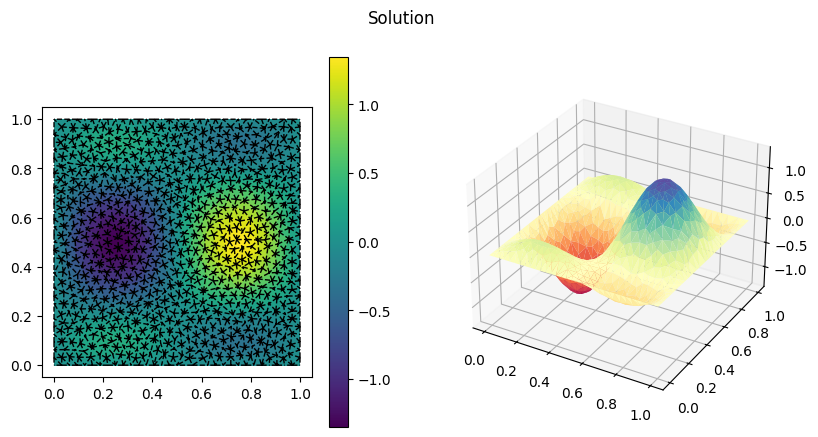

In [67]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)

gedim.ExportSolution(Test_exactSolution, u_k_proj, u_strong, lib)

# 2. **Parametric PINN**

## Import libraries

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# set SEEDS
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## The Network

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        # self.hidden_layer5 = nn.Linear(7,7)
        
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1): #we put sigmoid over all the layers
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1) # combines the column array
        layer1_out = torch.Softplus(self.input_layer(input)) #
        layer2_out = torch.Softplus(self.hidden_layer1(layer1_out))
        layer3_out = torch.Softplus(self.hidden_layer2(layer2_out))
        layer4_out = torch.Softplus(self.hidden_layer3(layer3_out))
        layer5_out = torch.Softplus(self.hidden_layer4(layer4_out))
        # layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        
        output = self.output_layer(layer5_out) #in the end only the output layer
        return output

#### Model Initialization

In [18]:
def Initialize_model(seed, lr): 
    torch.manual_seed(seed)
    net = Net()
    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, mse_cost_function, optimizer

### Residual computation function

In [25]:
## PDE as loss function.
def R(x_0, x_1, mu_0, mu_1, net, exact = False):
    
    u = net(x_0, x_1, mu_0 , mu_1) # previsione valore con rete
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0] #derivative of u over x_0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0] #second derivative of u over x_0

    
    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0] #derivative of u over x_1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0] #second derivative of u over x_1

    u_xx = u_xx0 + u_xx1

    if exact:
        g = torch.Tensor(32.0 * (x_1.detach().numpy() * (1.0 - x_1.detach().numpy()) + x_0.detach().numpy() * (1.0 - x_0.detach().numpy())) + \
                      	 +  mu_0.detach().numpy() / mu_1.detach().numpy() * (np.exp(mu_1.detach().numpy() * 16 * x_0.detach().numpy() * x_1.detach().numpy() * \
                         (1.0 - x_0.detach().numpy()) * (1.0 - x_1.detach().numpy()))-1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))
    
    f_nolin = mu_0 / mu_1 * (torch.exp(mu_1 * u)-1)
    
    pde = - u_xx + f_nolin - g

    # pde = - u_xx + f_nolin - g
    
    return pde

### Training set

In [26]:
# TRAINING SET BORDER
size = 200

x0_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))
x1_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))

all_zeros = np.zeros((size,1))
all_ones = np.ones((size,1))

l_x0 = np.concatenate([x0_bc, all_ones, x0_bc, all_zeros], axis=0)
l_x1 = np.concatenate([all_zeros, x1_bc, all_ones, x1_bc], axis=0)

#l_1 = np.concatenate([x0_bc, all_zeros], axis=1) # edge [0,1]x{0}
#l_2 = np.concatenate([all_ones, x1_bc], axis=1) # edge {1}x[0,1]
#l_3 = np.concatenate([x0_bc, all_ones], axis=1) # edge [0,1]x{1}
#l_4 =np.concatenate([all_zeros, x1_bc], axis=1) # edge {0}x[0,1]

u_bc = np.zeros((size*4,1))

# training set relative to mu
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))

In [27]:
# TRAINING SET INTERIOR POINTS
x0_int = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))
x1_int = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))

## 2.1 **Test function with exact solution**

 In order to implement an error study of the code we will implement, firstly we solve the Nonlinear Elliptic problem by means of PINN method over a Finite Element full order model by choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)$ and computing the respective right hand side define as

 $$
 g_{ex}(\mathbf{x};\mathbf{\mu}) = -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) = 32 (x_0(1-x_0)+x_1(1-x_1))+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
 $$
 
 Then we will apply our code to the problem introduced above.

## Offline phase: training

In [75]:

def training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, x0_int, x1_int, u_bc):
    loss_track = []
    for epoch in range(iterations):
        optimizer.zero_grad() # to make the gradients zero
    
        # Loss based on boundary conditions
        pt_x0_bc = Variable(torch.from_numpy(l_x0).float(), requires_grad=False)
        pt_x1_bc = Variable(torch.from_numpy(l_x1).float(), requires_grad=False)
    
        mu_0_tensor = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
        mu_1_tensor = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
        # mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(pt_x0_bc.size(0), 1)
        # mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(pt_x1_bc.size(0), 1)
        
        # condizione di dirichlet omogenea
        pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
        
        net_bc_out = net(pt_x0_bc, pt_x1_bc, mu_0_tensor, mu_1_tensor) # output of u(x)
        mse_u = mse_cost_function(net_bc_out, pt_u_bc)
        
        # Loss based on PDE
        all_zeros = np.zeros((size*4,1)) # 500 points over a line
        
        
        pt_x0_collocation = Variable(torch.from_numpy(x0_int).float(), requires_grad=True)
        pt_x1_collocation = Variable(torch.from_numpy(x1_int).float(), requires_grad=True)
    
        
        pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
        f_out = R(pt_x0_collocation, pt_x1_collocation, mu_0_tensor, mu_1_tensor, net, True) # output of R(x)
        mse_f = mse_cost_function(f_out, pt_all_zeros)
        
        # Combining the loss functions
        loss = mse_f + coeff * mse_u
        
        loss.backward() 
        optimizer.step()
    
        with torch.autograd.no_grad():
            if epoch % 100 == 0:
                print(epoch,"Loss:",loss.item())
                # print(f'{mse_f}, {mse_u}, {mse_f/mse_u}')
            if epoch % 10 == 0:
                loss_track.append(loss.item())
    return net, loss_track
        

In [53]:
coeff = 3000
lr = 0.01
iterations = 30000
losses = []
# for c in coeffs:
    #coeff = c
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
[net, training_loss] = training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, x0_int, x1_int, u_bc)
losses.append(training_loss)

0 Loss: 255.70651245117188
100 Loss: 133.2373809814453
200 Loss: 133.2356414794922
300 Loss: 133.23562622070312
400 Loss: 133.2353057861328
500 Loss: 133.23060607910156
600 Loss: 133.07460021972656
700 Loss: 98.10388946533203
800 Loss: 32.17619705200195
900 Loss: 22.335336685180664
1000 Loss: 18.652835845947266
1100 Loss: 9.823860168457031
1200 Loss: 7.173043727874756
1300 Loss: 7.810817241668701
1400 Loss: 4.65418815612793
1500 Loss: 3.9250354766845703
1600 Loss: 3.4372549057006836
1700 Loss: 3.052051067352295
1800 Loss: 2.781291961669922
1900 Loss: 2.5477256774902344
2000 Loss: 3.9268126487731934
2100 Loss: 2.2158191204071045
2200 Loss: 2.082387924194336
2300 Loss: 1.9787654876708984
2400 Loss: 1.8781074285507202
2500 Loss: 1.8318352699279785
2600 Loss: 1.7216451168060303
2700 Loss: 4.226479530334473
2800 Loss: 1.5987377166748047
2900 Loss: 1.5443947315216064
3000 Loss: 1.9477814435958862
3100 Loss: 1.452688455581665
3200 Loss: 1.4108766317367554
3300 Loss: 1.3764230012893677
3400 Lo

In [54]:
PATH = "model_exact.pth"
torch.save(net.state_dict(), PATH)

### Hyperparameters tuning

In [55]:
for i in range(len(losses)):
    print(f'Learning rate: {learning_rate[i]}')
    print(f'Loss: {losses[i][-1]}')

NameError: name 'learning_rate' is not defined

In [ ]:
for i in range(len(coeffs)):
    print(f'coeff: {coeffs[i]}')
    print(f'Loss: {losses[i][-1]}')

Learning rate: 0.1
Loss: 56.84489059448242 \
Learning rate: 0.01
Loss: 0.000976657378487289 \
Learning rate: 0.001
Loss: 0.0024526934139430523

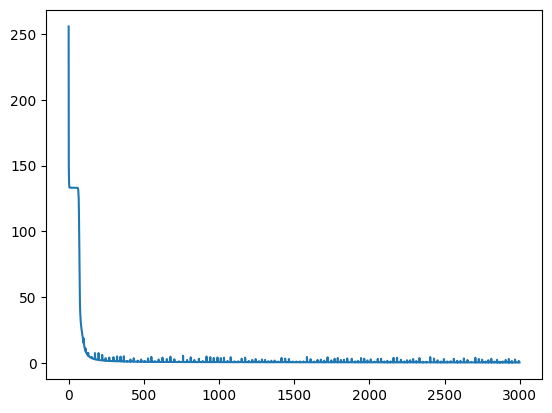

In [56]:
import matplotlib.pyplot as plt

plt.clf()
x = range(0, len(training_loss))
y = training_loss
plt.plot(x, y) 

## Online phase

In [103]:
meshSize = 0.001 #We choose a meshsize = maximum area required in our domain discretization
order = 1 #Order of finite element

#all the boundary condition are homogenous dirichlet boundary condition so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

# BoundaryConditionsType=2 means Dirichlet conditions
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

x0_bc = strongs[0].reshape(-1,1)
x1_bc = strongs[1].reshape(-1,1)

# transform to tensor
x_0_bc_tensor = Variable(torch.from_numpy(x0_bc).float(), requires_grad=False)
x_1_bc_tensor = Variable(torch.from_numpy(x1_bc).float(), requires_grad=False)

x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)

# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu_0 = 0.8
mu_1 = 0.4
mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)

mu_0_bc_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
mu_1_bc_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)

In [28]:
def predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, exact = False): 
    
    all_zeros = np.zeros((x_1_tensor.shape[0],1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
    u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)
    # mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    u_x0 = torch.autograd.grad(u_pred.sum(), x_0_tensor, create_graph=True)[0] #derivative of u over x_0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x_0_tensor, create_graph=True)[0]
    
    
    u_x1 = torch.autograd.grad(u_pred.sum(), x_1_tensor, create_graph=True)[0] #derivative of u over x_1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x_1_tensor, create_graph=True)[0] #second derivative of u over x_1
    
    u_xx = u_xx0 + u_xx1

    if exact:
        g = torch.Tensor(32.0 * (x_1_tensor.detach().numpy() * (1.0 - x_1_tensor.detach().numpy()) + x_0_tensor.detach().numpy() * (1.0 - x_0_tensor.detach().numpy())) + \
                             +  mu_0_tensor.detach().numpy() / mu_1_tensor.detach().numpy() * (np.exp(mu_1_tensor.detach().numpy() * 16 * x_0_tensor.detach().numpy() * x_1_tensor.detach().numpy() * \
                            (1.0 - x_0_tensor.detach().numpy()) * (1.0 - x_1_tensor.detach().numpy()))-1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0_tensor.detach().numpy()) * np.cos(2 * np.pi * x_1_tensor.detach().numpy()))
    
    f_nolin = mu_0_tensor / mu_1_tensor * (torch.exp(mu_1_tensor * u_pred)-1)
    
    pde = - u_xx + f_nolin - g

    mse_f = mse_cost_function(pde, pt_all_zeros)
    

    # u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)

    return u_pred, mse_f
    

In [105]:
# EVALUATION MODE- from pretrained model
PATH = "model_exact.pth"
lr = 0.01
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [106]:
[predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, exact = True)

### Errors w.r.t. different mesh sizes

In [92]:
################## EXACT SOLUTION ###################
# Evaluation in quadrature points
def ExactSolution(quadraturePoints):
    values_ex = 16.0 * (quadraturePoints[1] * (1.0 - quadraturePoints[1]) * quadraturePoints[0] * (1.0 - quadraturePoints[0]))
    return values_ex

# Derivatives in each direction
def ExactDerivativeSolution(quadraturePoints):
    values_ex_x = 16.0 * (1.0 - 2.0 * quadraturePoints[0]) * quadraturePoints[1] * (1.0 - quadraturePoints[1])
    values_ex_y = 16.0 * (1.0 - 2.0 * quadraturePoints[1]) * quadraturePoints[0] * (1.0 - quadraturePoints[0])

    values_ex_d = [values_ex_x, values_ex_y]

    return values_ex_d
#####################################################

In [93]:
#Nella costruzione delle funzioni non ci interessava sapere chi fossero i nodi di quadratura per la costruzione delle matrici. In questo caso invece, dovendo valutare l'errore in tutte
#le celle dobbiamo conoscere i nodi di quadratura in tutto il dominio e li salviamo nella matrice globale quadraturePoints
#Inoltre per ogni nodo di quadratura dobbiamo conoscere il peso per cui dobbiamo moltiplicare, altrimenti l'approssimazione dell'integrale non è corretta. 
#La sommma dei pesi è 1 poichè approssimo l'integrale della funzione unitaria che fornisce la misura del nostro dominio
def compute_error(predPoints, u_strong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(predPoints, u_strong, lib)
    error_L2_PINN = np.float64(0)
    error_H1_PINN = np.float64(0)
    norm_L2_ex = 0
    norm_H1_ex = 0
    
    for q in range(numQuadraturePoints):
        sol_ex = ExactSolution(quadraturePoints[:, q])
        sol_ex_d = ExactDerivativeSolution(quadraturePoints[:, q])
        
        error_L2_PINN += quadratureWeights[q] * np.square(sol_ex - sol[q])
        error_H1_PINN += quadratureWeights[q] * (np.square(sol_ex_d[0] - sol_x[q]) + np.square(sol_ex_d[1] - sol_y[q]))
        
        norm_L2_ex += quadratureWeights[q] * (np.square(sol_ex))
        norm_H1_ex += quadratureWeights[q] * (np.square(sol_ex_d[0]) + np.square(sol_ex_d[1]))
        
    return np.sqrt(error_L2_PINN), np.sqrt(error_H1_PINN), np.sqrt(norm_L2_ex), np.sqrt(norm_H1_ex), sol, numQuadraturePoints, quadraturePoints
   
    

In [107]:
predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)

# u_strong = u_strong.data.cpu().numpy().astype(np.float64)
# u_strong = u_strong.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [95]:
[error_L2_PINN, error_H1_PINN, norm_L2_ex, norm_H1_ex, sol, numQuadraturePoints, quadraturePoints] = compute_error(predPoints, u_strong)

In [96]:
meshSizes = [0.01, 0.001, 0.0001]

errabs_L2_PINN = []
errrel_L2_PINN = []
errabs_H1_PINN = []
errrel_H1_PINN = []

for meshSize in meshSizes:
    # Build Mesh
    [meshInfo, mesh, problemData, dofs, strongs] = set_geom_param(lib, meshSize)

    #test set
    x0_bc = strongs[0].reshape(-1,1)
    x1_bc = strongs[1].reshape(-1,1)
    
    # transform to tensor
    x_0_bc_tensor = Variable(torch.from_numpy(x0_bc).float(), requires_grad=False)
    x_1_bc_tensor = Variable(torch.from_numpy(x1_bc).float(), requires_grad=False)
    
    x0 = dofs[0].reshape(-1,1)
    x1 = dofs[1].reshape(-1,1)
    
    # transform to tensor
    x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
    x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)
    
    mu_0 = 0.8
    mu_1 = 0.4
    mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    
    mu_0_bc_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
    mu_1_bc_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
    
    # compute Predicted solution points using PINN
    [predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, True)
    predPoints = predPoints.data.cpu().numpy().astype(np.float64)
    predPoints = predPoints.reshape(-1)
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    
    # compute error
    [error_L2_PINN, error_H1_PINN, norm_L2_ex, norm_H1_ex, sol, numQuadraturePoints, quadraturePoints] = compute_error(predPoints, u_strong)
    # save errors
    errabs_L2_PINN.append(error_L2_PINN)
    errrel_L2_PINN.append(error_L2_PINN/norm_L2_ex)
    
    errabs_H1_PINN.append(error_H1_PINN)
    errrel_H1_PINN.append(error_H1_PINN/norm_H1_ex)

<Figure size 640x480 with 0 Axes>

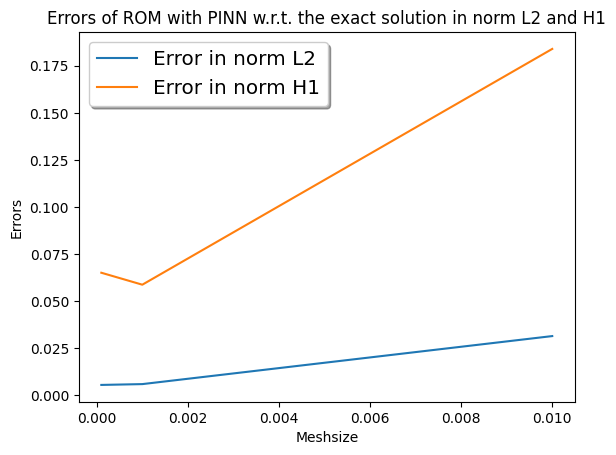

In [97]:
plt.clf()
x = [0.01, 0.001, 0.0001]
y = errrel_L2_PINN
# plt.plot(x, y) 

# y = errrel_H1_PINN
# plt.plot(x, y) 

fig, ax = plt.subplots()
ax.plot(x, y, label='Error in norm L2')

y = errrel_H1_PINN
ax.plot(x, y, label='Error in norm H1')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("Errors of ROM with PINN w.r.t. the exact solution in norm L2 and H1")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_L2_H1_PINN.png")

In [98]:
pcoeff_L2 = np.polyfit(np.log(x), np.log(errrel_L2_PINN), 1)
pcoeff_H1 = np.polyfit(np.log(x), np.log(errabs_H1_PINN), 1)
order_L2 = pcoeff_L2[0]
order_H1 = pcoeff_H1[0]
print("order_L2", "order_H1")
print(order_L2, order_H1)

order_L2 order_H1
0.3787332037463467 0.22563119363768477


In [99]:
with open("orders_PINN.txt", "w") as file:
    file.write(f"{order_L2}, {order_H1}")

df = pd.DataFrame({'Order_L2': [order_L2], 'Order_H1': [order_H1]})
df.to_csv("orders_PINN.csv")

### Errors and speed-up of PINN w.r.t FOM 

CALCOLARE LA MEDIA DELLA SPEED UP SU UN TESTING SET DI PARAMETRI

In [61]:
import time

In [62]:
def compute_time_PINN(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net):
    tot_time = np.zeros(100)
    for i in range(100):
        start = time.time()
        [predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, True)
        predict_time = time.time() - start
        tot_time[i] = predict_time
    mean_time = np.mean(tot_time)
    print(f'Mean PINN prediction time:')
    print(mean_time)
    return mean_time
# [u_strong, mse_bc] =predict_bc(x_0_bc_tensor, x_1_bc_tensor, mu_0_bc_tensor, mu_1_bc_tensor, net, True)

In [63]:
mesh_sizes = [0.001]
mu = [0.8, 0.4]

snapshot_num = 5
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

speed_up_ROM_PINN = []
speed_up_FOM_PINN = []
mean_time_PINN_list = []

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

for mesh_size in mesh_sizes:
    # Build Mesh
    [meshInfo, mesh, problemData, dofs, strongs] = set_geom_param(lib, mesh_size)
    #ROM
    #Build snapshot matrix
    snapshot_matrix = build_snapshot_matrix(problemData, training_set)
    # POD
    [N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)
    basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)
    # Compute FOM
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
    # Compute ROM 
    [u_k, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=True)
    # Compute speed-up ROM-FOM
    speed_up_ROM_FOM = sum(time_FOM+time_assembling_FOM)/sum(time_ROM+time_assembling_ROM)
    # PINN
    mean_time_PINN = compute_time_PINN(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net)
    mean_time_PINN_list.append(mean_time_PINN)
    # Compute speed-up ROM-PINN
    speed_up_ROM_PINN.append((sum(time_ROM+time_assembling_ROM))/mean_time_PINN)
    speed_up_FOM_PINN.append((sum(time_FOM+time_assembling_FOM))/mean_time_PINN)
    
    

Params: [0.22710118903583454, 0.6137896751555286]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6030723100321875e-03 5.1344473091328169e-02 3.5094415220396735e-07 3 20
Params: [0.26674331984499133, 0.35077875680353277]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 4.4521671882391299e-03 5.1438512342599815e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6027789782394908e-03 5.1344456556089310e-02 6.4493991347381952e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.434102

[481.93540530880483, 540.6871319729782, 497.540367978325]

### Plot

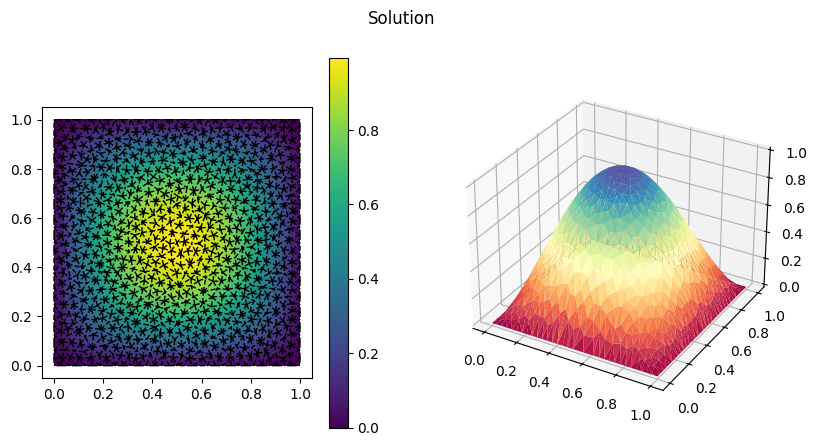

In [108]:
gedim.PlotSolution(mesh, dofs, strongs, predPoints, u_strong)

gedim.ExportSolution(Test_exactSolution, predPoints, u_strong, lib)

# 2.2 **Project task**
From the error study we have seen that our code give a good approximation of the exact solution. We now implement the code in order to find an approximation of the unknown solution of the nonlinear elliptic problem with the forcing term equal to 
$$
g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
$$

### Offline phase: training and fitting

In [29]:
# TRAINING SET BORDER
size = 1000

x0_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))
x1_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))

all_zeros = np.zeros((size,1))
all_ones = np.ones((size,1))

l_x0 = np.concatenate([x0_bc, all_ones, x0_bc, all_zeros], axis=0)
l_x1 = np.concatenate([all_zeros, x1_bc, all_ones, x1_bc], axis=0)

#l_1 = np.concatenate([x0_bc, all_zeros], axis=1) # edge [0,1]x{0}
#l_2 = np.concatenate([all_ones, x1_bc], axis=1) # edge {1}x[0,1]
#l_3 = np.concatenate([x0_bc, all_ones], axis=1) # edge [0,1]x{1}
#l_4 =np.concatenate([all_zeros, x1_bc], axis=1) # edge {0}x[0,1]

u_bc = np.zeros((size*4,1))

In [30]:
# TRAINING SET RELATIVE TO mu
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))

In [31]:
# TRAINING SET INTERIOR POINTS
x0_int = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))
x1_int = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))

In [ ]:

from torch.optim.lr_scheduler import StepLR

In [32]:
def training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, x0_int, x1_int, u_bc):
    loss_track = []
    scheduler = StepLR(optimizer, step_size=500, gamma=0.5)
    for epoch in range(iterations):
        optimizer.zero_grad() # to make the gradients zero
    
        # Loss based on boundary conditions
        pt_x0_bc = Variable(torch.from_numpy(l_x0).float(), requires_grad=False)
        pt_x1_bc = Variable(torch.from_numpy(l_x1).float(), requires_grad=False)
    
        mu_0_tensor = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
        mu_1_tensor = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
        # mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(pt_x0_bc.size(0), 1)
        # mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(pt_x1_bc.size(0), 1)
        
        # condizione di dirichlet omogenea
        pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
        
        net_bc_out = net(pt_x0_bc, pt_x1_bc, mu_0_tensor, mu_1_tensor) # output of u(x)
        mse_u = mse_cost_function(net_bc_out, pt_u_bc)
        
        # Loss based on PDE
        all_zeros = np.zeros((size*4,1)) # 500 points over a line
        
        pt_x0_collocation = Variable(torch.from_numpy(x0_int).float(), requires_grad=True)
        pt_x1_collocation = Variable(torch.from_numpy(x1_int).float(), requires_grad=True)
    
        
        pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
        f_out = R(pt_x0_collocation, pt_x1_collocation, mu_0_tensor, mu_1_tensor, net) # output of R(x)
        mse_f = mse_cost_function(f_out, pt_all_zeros)
        
        # Combining the loss functions
        loss = mse_f + coeff * mse_u
        
        
        loss.backward() 
        optimizer.step()
        scheduler.step()
    
        with torch.autograd.no_grad():
            if epoch % 1000 == 0:
                print(epoch,"Loss:",loss.item())
                print(f'{mse_f}, {mse_u}, {mse_f/mse_u}')
            if epoch % 10 == 0:
                loss_track.append(loss.item())
    return net, loss_track
        

In [33]:
# HYPERPARAMETERS SETTING
coeff = 5000
lr = 0.01
iterations = 30000

PATH = "model.pth"
# losses = []

In [119]:
# TRAINING
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
[net, training_loss] = training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, x0_int, x1_int, u_bc)
torch.save(net.state_dict(), PATH)
# losses.append(training_loss)

0 Loss: 2686.912841796875
2478.472412109375, 0.041688065975904465, 59452.8046875
1000 Loss: 2478.071533203125
2478.0712890625, 3.1918599319169516e-08, 77637222400.0
2000 Loss: 2478.071533203125
2478.0712890625, 3.192302244769962e-08, 77626458112.0
3000 Loss: 394.70941162109375
314.1426696777344, 0.016113346442580223, 19495.8046875
4000 Loss: 49.097904205322266
35.887596130371094, 0.0026420617941766977, 13583.177734375
5000 Loss: 29.70028305053711
22.811899185180664, 0.0013776767300441861, 16558.23828125
6000 Loss: 22.746061325073242
16.688753128051758, 0.0012114617275074124, 13775.716796875
7000 Loss: 18.64743423461914
12.856104850769043, 0.0011582659790292382, 11099.44140625
8000 Loss: 26.450645446777344
10.585098266601562, 0.0031731093768030405, 3335.875732421875
9000 Loss: 13.544713020324707
8.192981719970703, 0.0010703462176024914, 7654.515625
10000 Loss: 12.099925994873047
7.17436408996582, 0.0009851123904809356, 7282.78759765625
11000 Loss: 11.247838020324707
6.6328840255737305, 

In [34]:
## EVALUATION MODE- from pretrained model
PATH = "model.pth"
lr = 0.01
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [123]:
training_loss[-20:]

[25.103012084960938,
 13.197272300720215,
 8.219757080078125,
 7.346196174621582,
 7.303603172302246,
 7.302549362182617,
 7.293560981750488,
 7.287581443786621,
 7.284787654876709,
 7.282526969909668,
 7.279465675354004,
 7.276286602020264,
 7.273721694946289,
 7.2712507247924805,
 7.268836975097656,
 7.266473770141602,
 7.264150619506836,
 7.261837005615234,
 7.259575843811035,
 7.257303237915039]

### Hyper-parameters tuning

In [93]:
for i in range(len(losses)):
    print(f'Learning rate: {learning_rates[i]}')
    print(f'Loss: {losses[i][-1]}')

NameError: name 'learning_rates' is not defined

Learning rate: 0.1
Loss: 0.7125176191329956 \
Learning rate: 0.01
Loss: 0.31939148902893066 \
Learning rate: 0.001
Loss: 10.125948905944824 \

<Figure size 640x480 with 0 Axes>

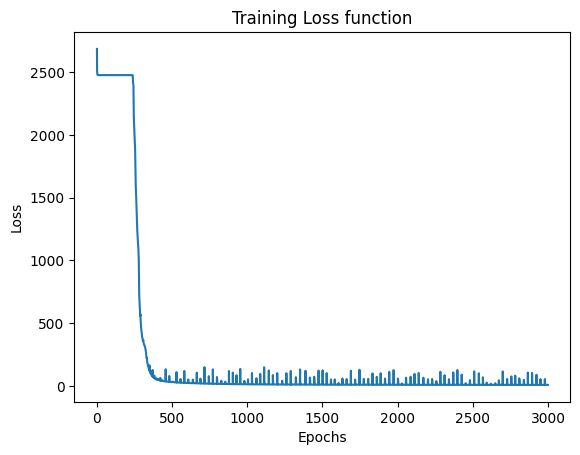

In [124]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()
x = range(0, len(training_loss))
y = training_loss
plt.plot(x, y)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss.png')

## Online phase

In [125]:
## EVALUATION MODE- from pretrained model
PATH = "model.pth"
lr = 0.01
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
# TEST SET INTERIOR POINTS
x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)

# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu_0 = 0.8
mu_1 = 0.4
mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)

In [41]:
[predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, False)

In [37]:
print(f'Test MSE: {mse}')

Test MSE: 2.7238659858703613


### Errors and speed-up of PINN w.r.t FOM

In [38]:
def compute_time_PINN(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net):
    tot_time = np.zeros(100)
    for i in range(100):
        start = time.time()
        [predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, False)
        predict_time = time.time() - start
        tot_time[i] = predict_time
    mean_time = np.mean(tot_time)
    print(f'Mean PINN prediction time:')
    print(mean_time)
    return mean_time

In [39]:
def compute_error_PINN_FOM(predPoints,predPointsFom, u_strong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(predPoints, u_strong, lib)
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol_fom, sol_x_fom, sol_y_fom] = gedim.EvaluateSolutionOnPoints(predPointsFom, u_strong, lib)
    
    error_L2_PINN = np.float64(0)
    error_H1_PINN = np.float64(0)
    norm_L2_fom = 0
    norm_H1_fom = 0

    for q in range(numQuadraturePoints):
        
        error_L2_PINN += quadratureWeights[q] * np.square(sol_fom[q] - sol[q])
        error_H1_PINN += quadratureWeights[q] * (np.square(sol_x_fom[q] - sol_x[q]) + np.square(sol_y_fom[q] - sol_y[q]))
        
        norm_L2_fom += quadratureWeights[q] * (np.square(sol_fom[q]))
        norm_H1_fom += quadratureWeights[q] * (np.square(sol_x_fom[q]) + np.square(sol_y_fom[q]))
        
    return np.sqrt(error_L2_PINN), np.sqrt(error_H1_PINN), np.sqrt(norm_L2_fom), np.sqrt(norm_H1_fom), sol, numQuadraturePoints, quadraturePoints

In [40]:
import time

abs_err_L2 = []
rel_err_L2 = []
abs_err_H1 = []
rel_err_H1 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(10, P.shape[0]))
speed_up = []

u_strong = np.zeros(problemData['NumberStrongs'], order='F')

for mu in testing_set:
    [u, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=False)

    mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)

    mean_time_PINN = compute_time_PINN(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net)
    
    speed_up.append(sum(time_FOM+time_assembling_FOM)/mean_time_PINN)

    [predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net, False)
    predPoints = predPoints.data.cpu().numpy().astype(np.float64)
    predPoints = predPoints.reshape(-1)

    [error_L2_PINN_FOM, error_H1_PINN_FOM, norm_L2_fom, norm_H1_fom, sol, numQuadraturePoints, quadraturePoints] = compute_error_PINN_FOM(predPoints, predPointsFom, u_strong)
    abs_err_L2.append(error_L2_PINN_FOM)
    abs_err_H1.append(error_H1_PINN_FOM)
    
    rel_err_L2.append(error_L2_PINN_FOM/norm_L2_fom)
    rel_err_H1.append(error_H1_PINN_FOM/norm_H1_fom)

Params: [0.9607776599599552, 0.8805554973002008]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.4220535913968164e-02 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 4.5571452006445586e-06 3 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.3866468827614253e-13 4 20
Mean PINN prediction time:
0.0031093621253967287


NameError: name 'predPointsFom' is not defined

In [145]:
with open("speed_up_PINN_quadform.txt", "w") as file:
    file.write(f"{np.mean(rel_err_L2)},{np.mean(abs_err_L2)},{np.mean(rel_err_H1)}, {np.mean(abs_err_H1)}, {np.mean(tot_speed_up)}")

df = pd.DataFrame({'Error_rel_L2_FOM_ROM': [np.mean(rel_err_L2)],'Error_abs_L2_FOM_ROM': [np.mean(abs_err_L2)],'Error_rel_H1_FOM_ROM': [np.mean(rel_err_H1)], 'Error_abs_H1_FOM_ROM': [np.mean(abs_err_H1)], 'Speed_up_POD': [np.mean(tot_speed_up)]})
df.to_csv("speed_up_PINN_quadform.csv")

### Plot

In [146]:
mu_0 = 0.8
mu_1 = 0.4
mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)

In [147]:
[predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net)

In [148]:
predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

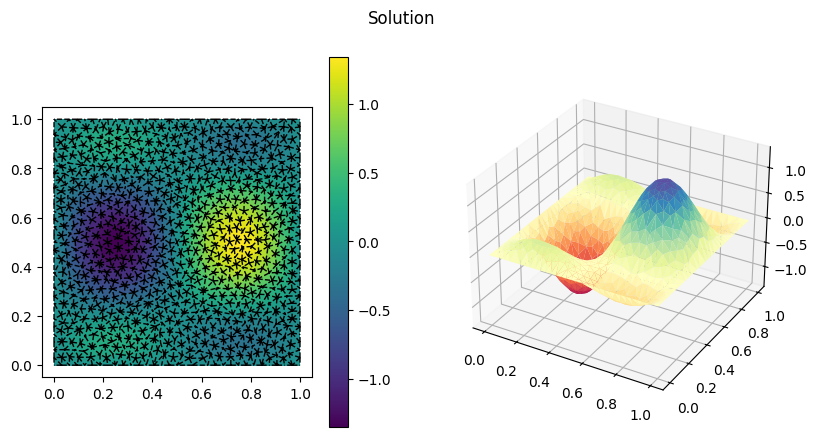

In [119]:
#Visualizzazione della soluzione e calcolo dell'errore FONDAMENTALI NEL PROGETTO !!!
gedim.PlotSolution(mesh, dofs, strongs, predPoints, u_strong)

#PLotSolution implements in Pyton the two plot of 2D and 3D plots of the solution. IT's better to export the solution in order to visulize the solution in other applications, as ParaView
#ExportSolution give us a file .inp which is the file format of the UCD structur file. It's limitated to specific type of geometrical elemntsù: tringle hexahedron, thetraedron, pyramidon, line, points.
# Filter "Warp by scalar" in ParaView let choos one of the scalar associated to the solution... to 3D visualization

gedim.ExportSolution(Test_exactSolution, predPoints, u_strong, lib)

## 3. Solve the problem with the POD-NN approach and compare it to the other two strategies

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [17]:
# set SEEDS
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 3.1 **Benchmark problem**

In order to implement an error study of the code we will implement, firstly we solve the Nonlinear Elliptic problem by means of POD-Galerkin method over a Finite Element full order model by choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)$ and computing the respective right hand side define as

 $$
 g_{ex}(\mathbf{x};\mathbf{\mu}) = -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) = 32 (x_0(1-x_0)+x_1(1-x_1))+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
 $$
 
 Then we will apply our code to the problem introduced above.

### Offline phase: building reduced space

In [85]:
### define the training set

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

# set random seed for a reproducible work
np.random.seed(1)

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

In [86]:
snapshot_matrix = build_snapshot_matrix(problemData, training_set)

Params: [0.47531980423231657, 0.7482920440979423]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 1.9341357699591119e-03 5.1297356729048026e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6438903949875755e-03 5.1346781967051523e-02 3.5831094634866337e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6439402188454951e-03 5.1346784812177172e-02 5.9221145541472920e-08 3 20
Params: [0.1001029373356104, 0.3720993153686558]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 1.9341357699591119e-03 5.1297356729048026e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.4341029499729044e-02 2.6438903949875755e-03 5.1346781967051523e-02 3.5831094634866337e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
713 6.43410294

In [87]:
[N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)

The reduced dimension is 1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [88]:
basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)

Basis functions dimension: (713, 1)


### Offline phase: building NN

In [95]:
import torch.nn.functional as F

mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

P = np.array([mu1_range, mu2_range])

mu_dim = P.shape
basis_dim = N # dimension of the reduced space
input_dim = mu_dim # equal to the dim of parameter space
output_dim = basis_dim # basis number chosen before
nodes = 30 # number of nodes inside

# parameters in input

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(2, 30) 
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 30)
        self.fc5 = nn.Linear(30, 1) # 4 layers before the output
        self.tanh = nn.Tanh() #activation function
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
        return x

In [18]:
def Initialize_model(seed, lr=0.01): 
    torch.manual_seed(seed)
    net = Net()
    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, mse_cost_function, optimizer

In [102]:
seed_num = 31
torch.manual_seed(seed_num)
[net, my_loss, optimizer] = Initialize_model(seed_num)
torch.set_default_dtype(torch.float32)

epoch_max = 10000
epoch = 0
tol = 1e-5
loss = 1.

### Offline phase: training

In [97]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
y_train = []

#given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)

for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)

In [93]:
from torch.optim.lr_scheduler import StepLR

In [103]:
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)

while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  loss.backward()
  # optimizer update
  optimizer.step() 
  scheduler.step()
  print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

epoch 1 loss 5.67689847946167 lr 0.01
epoch 2 loss 4.273427486419678 lr 0.01
epoch 3 loss 2.788830518722534 lr 0.01
epoch 4 loss 1.3174989223480225 lr 0.01
epoch 5 loss 0.30465802550315857 lr 0.01
epoch 6 loss 0.0002644599007908255 lr 0.01
epoch 7 loss 0.1785743087530136 lr 0.01
epoch 8 loss 0.42004886269569397 lr 0.01
epoch 9 loss 0.509718656539917 lr 0.01
epoch 10 loss 0.4547499120235443 lr 0.01
epoch 11 loss 0.32226088643074036 lr 0.01
epoch 12 loss 0.1763046681880951 lr 0.01
epoch 13 loss 0.06291688233613968 lr 0.01
epoch 14 loss 0.006017167121171951 lr 0.01
epoch 15 loss 0.007093026768416166 lr 0.01
epoch 16 loss 0.048516202718019485 lr 0.01
epoch 17 loss 0.10216554999351501 lr 0.01
epoch 18 loss 0.14209352433681488 lr 0.01
epoch 19 loss 0.15422306954860687 lr 0.01
epoch 20 loss 0.1380917876958847 lr 0.009000000000000001
epoch 21 loss 0.10278861969709396 lr 0.009000000000000001
epoch 22 loss 0.06500356644392014 lr 0.009000000000000001
epoch 23 loss 0.031150488182902336 lr 0.009000

In [104]:
PATH = "model_exact_PODNN.pth"
torch.save(net.state_dict(), PATH)

### Online phase

In [105]:
## EVALUATION MODE- from pretrained model
PATH = "model_exact_PODNN.pth"
lr = 0.01
[net, mse_cost_function, optimizer] = Initialize_model(seed, lr)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
def predict_PODNN(x_test, net): 
    
    x_test = np.float32(x_test)
    x_test = torch.tensor(x_test)
    
    reduced_solution = np.asarray(net(x_test).detach().numpy())[0] #we transform the tensor in an array form

    u_proj = basis_functions @ reduced_solution # we want to see the solution in the high fidelity setting

    return u_proj
    

In [107]:
#we compute the solution
x_test = [[.8, .4]] # they are different parameters from that chosen for the POD !
u_proj = predict_PODNN(x_test, net)

### Errors w.r.t. different mesh sizes

In [108]:
################## EXACT SOLUTION ###################
# Evaluation in quadrature points
def ExactSolution(quadraturePoints):
    values_ex = 16.0 * (quadraturePoints[1] * (1.0 - quadraturePoints[1]) * quadraturePoints[0] * (1.0 - quadraturePoints[0]))
    return values_ex

# Derivatives in each direction
def ExactDerivativeSolution(quadraturePoints):
    values_ex_x = 16.0 * (1.0 - 2.0 * quadraturePoints[0]) * quadraturePoints[1] * (1.0 - quadraturePoints[1])
    values_ex_y = 16.0 * (1.0 - 2.0 * quadraturePoints[1]) * quadraturePoints[0] * (1.0 - quadraturePoints[0])

    values_ex_d = [values_ex_x, values_ex_y]

    return values_ex_d
#####################################################

In [109]:
def compute_error_exact_PODNN(u_proj, u_strong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_proj, u_strong, lib)
    error_L2 = np.float64(0)
    error_H1 = np.float64(0)
    norm_L2_ex = 0
    norm_H1_ex = 0

    #sol_ex = np.zeros(numQuadraturePoints, dtype=np.double)
    print(numQuadraturePoints)
    
    for q in range(numQuadraturePoints):
        sol_ex = ExactSolution(quadraturePoints[:, q])
        sol_ex_d = ExactDerivativeSolution(quadraturePoints[:, q])
        
        error_L2 += quadratureWeights[q] * np.square(sol_ex - sol[q])
        error_H1 += quadratureWeights[q] * (np.square(sol_ex_d[0] - sol_x[q]) + np.square(sol_ex_d[1] - sol_y[q]))
        
        norm_L2_ex += quadratureWeights[q] * (np.square(sol_ex))
        norm_H1_ex += quadratureWeights[q] * (np.square(sol_ex_d[0]) + np.square(sol_ex_d[1]))
        
    return np.sqrt(error_L2), np.sqrt(error_H1), np.sqrt(norm_L2_ex), np.sqrt(norm_H1_ex), sol, numQuadraturePoints, quadraturePoints

In [110]:
mesh_sizes = [0.1, 0.01, 0.001]
mu = [0.8, 0.4]

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

error_L2_abs = []
error_H1_abs = []
error_L2_rel = []
error_H1_rel = []

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

for mesh_size in mesh_sizes:
    # Build Mesh
    [meshInfo, mesh, problemData, dofs, strongs] = set_geom_param(lib, mesh_size)
    #ROM
    #Build reduced space
    snapshot_matrix = build_snapshot_matrix(problemData, training_set)
    [N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)
    basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)

    #Build NN
    mu1_range = [0.1, 1.]
    mu2_range = [0.1, 1.]
    
    P = np.array([mu1_range, mu2_range])
    
    mu_dim = P.shape
    basis_dim = N # dimension of the reduced space
    input_dim = mu_dim # equal to the dim of parameter space
    output_dim = basis_dim # basis number chosen before
    nodes = 30 # number of nodes inside
    
    # parameters in input
    
    class Net(nn.Module):
    
        def __init__(self):
            super(Net, self).__init__()
            self.nodes = nodes
            self.fc1 = nn.Linear(2, 30) 
            self.fc2 = nn.Linear(30, 30)
            self.fc3 = nn.Linear(30, 30)
            self.fc4 = nn.Linear(30, 30)
            self.fc5 = nn.Linear(30, 1) # 4 layers before the output
            self.tanh = nn.Tanh() #activation function
            # self.apply(self._init_weights)
    
    
        def forward(self, x):  ### Forward law ----> prediction
            x = self.tanh(self.fc1(x))   
            x = self.tanh(self.fc2(x))
            x = self.tanh(self.fc3(x))
            x = self.tanh(self.fc4(x))
            x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
            return x

    #Initialization
    seed_num = 31
    torch.manual_seed(seed_num)
    [net, my_loss, optimizer] = Initialize_model(seed)
    torch.set_default_dtype(torch.float32)
    
    epoch_max = 10000
    epoch = 0
    tol = 1e-5
    loss = 1.
    
    #Build training set
    ####### training set ########
    reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
    x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
    y_train = []
    
    #given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)
    
    for i in range(snapshot_matrix.shape[0]):
      
      snapshot_to_project = snapshot_matrix[i]
      
      projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
      
      y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)
    
    y_train = np.float32(y_train)
    y_train = torch.tensor(y_train)

    #Training
    while loss >= tol and epoch < epoch_max:
      epoch = epoch + 1
      optimizer.zero_grad()
              
      ## compute output
      output = net(x_train)
      
              
      loss = my_loss(output, y_train)
      if epoch >= 20000:
        optimizer.param_groups[0]['lr'] = 0.0001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
      #compute the gradients
      loss.backward()
      # optimizer update
      optimizer.step() # update the lr??
      print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

    #Prediction
    x_test = [[.8, .4]]
    u_proj = predict_PODNN(x_test, net)

    # Compute Errors
    [error_L2_ROM, error_H1_ROM, norm_L2_ex, norm_H1_ex, sol, numQuadraturePoints, quadraturePoints] = compute_error_exact_PODNN(u_proj, u_strong)

    error_L2_abs.append(error_L2_ROM)
    error_H1_abs.append(error_H1_ROM)
    error_L2_rel.append(error_L2_ROM/norm_L2_ex)
    error_H1_rel.append(error_H1_ROM/norm_H1_ex)
    

Params: [0.7071076213870695, 0.8197988832076476]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329209e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718222e-01 4.8625662491747496e-01 4.9258543010460764e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237306685114831e-01 4.8625669401105714e-01 1.5113890749890391e-07 3 20
Params: [0.1724765744155473, 0.30853207943721284]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.2729351333329209e-01 4.8402945417052468e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01 2.3237291044718222e-01 4.8625662491747496e-01 4.9258543010460764e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
5 5.0000000000000000e-01

<Figure size 640x480 with 0 Axes>

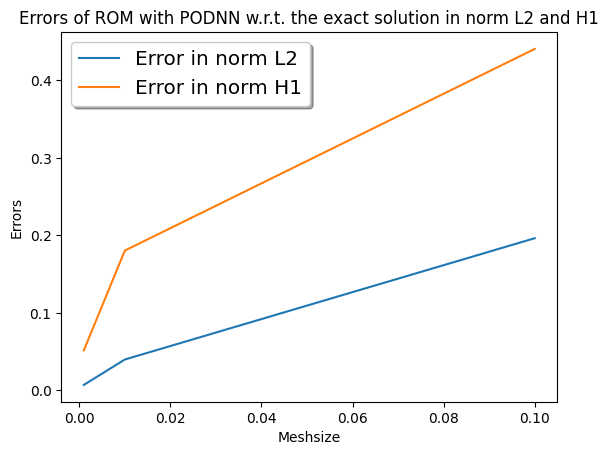

In [111]:
plt.clf()
x = [0.1, 0.01, 0.001]
y = error_L2_rel
# plt.plot(x, y) 

# y = errrel_H1_PINN
# plt.plot(x, y) 

fig, ax = plt.subplots()
ax.plot(x, y, label='Error in norm L2')

y = error_H1_rel
ax.plot(x, y, label='Error in norm H1')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("Errors of ROM with PODNN w.r.t. the exact solution in norm L2 and H1")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_L2_H1_PDNN.png")

In [114]:
pcoeff_L2 = np.polyfit(np.log(x), np.log(error_L2_rel), 1)
pcoeff_H1 = np.polyfit(np.log(x), np.log(error_H1_rel), 1)
order_L2 = pcoeff_L2[0]
order_H1 = pcoeff_H1[0]
print("order_L2", "order_H1")
print(order_L2, order_H1)

order_L2 order_H1
0.7265737120561907 0.4662206887600675


In [113]:
with open("orders_PDNNvsEXACT.txt", "w") as file:
    file.write(f"{order_L2}, {order_H1}")

df = pd.DataFrame({'Order_L2': [order_L2], 'Order_H1': [order_H1]})
df.to_csv("orders_PDNNvsEXACT.csv")

### Plot

In [115]:
u_strong = np.zeros(problemData['NumberStrongs'], order='F') 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, u_strong)

NameError: name 'nn_proj_reduced_solution' is not defined

# 3.1 **Task problem**

In [38]:
seed_num = 31
torch.manual_seed(seed_num)
[net, my_loss, optimizer] = Initialize_model(seed_num, 0.01)
torch.set_default_dtype(torch.float32)
epoch_max = 10000
epoch = 0
tol = 1e-5
loss = 1.

### Offline phase: building reduced space

In [24]:
################################ SNAPSHOT MATRIX ##############################
snapshot_matrix = []

mu = [0.8, 0.4]

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

tol = 1. - 1e-7
N_max = 10
num_iteration = 1 
# variable storing the index i i-th sample parameters considered
i = 1

for mu in training_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm] = compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=False)
    snapshot_matrix.append(np.copy(u_k))
    i = i+1

snapshot_matrix = np.array(snapshot_matrix)

Params: [0.4370861069626263, 0.9556428757689246]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.4163271633055639e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 6.9137768298502001e-07 3 20
Params: [0.7587945476302645, 0.6387926357773329]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 8.0240558981389664e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.0472659871337923e-07 3 20
Params: [0.24041677639819287, 0.2403950683025824]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 9.6022674978820299e-04 2 20
dofs h residual iterati

In [25]:
[N, inner_product, eigenvectors] = covariance_matrix(snapshot_matrix)

The reduced dimension is 3
[0.9999922  0.99999917 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.    

In [26]:
basis_functions = create_basis_functions(N, snapshot_matrix, inner_product, eigenvectors)

Basis functions dimension: (713, 3)


### Offline phase: building NN

In [27]:
import torch.nn.functional as F

mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

P = np.array([mu1_range, mu2_range])

# mu_dim = P.shape
 # dimension of the reduced space
# input_dim = mu_dim # equal to the dim of parameter space
# output_dim = basis_dim # basis number chosen before
nodes = 30 # number of nodes inside

# parameters in input

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(2, 30) 
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 30)
        self.fc5 = nn.Linear(30, 3) # 4 layers before the output
        self.Softplus = nn.Softplus() #activation function
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.Softplus(self.fc1(x))   
        x = self.Softplus(self.fc2(x))
        x = self.Softplus(self.fc3(x))
        x = self.Softplus(self.fc4(x))
        x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
        return x

### Offline phase: training

In [39]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
y_train = []

#given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)

for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)

In [41]:
from torch.optim.lr_scheduler import StepLR

In [55]:
seed_num = 42
torch.manual_seed(seed_num)
[net, my_loss, optimizer] = Initialize_model(seed_num, 0.01)
torch.set_default_dtype(torch.float32)

epoch_max = 15000
epoch = 0
tol = 1e-5
loss = 1.

scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)
training_loss = []

while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  #if epoch >= 500:
    #optimizer.param_groups[0]['lr'] = 0.001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
  #if epoch >= 4000:
    #optimizer.param_groups[0]['lr'] = 0.0001
    #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step() # update the lr??
  scheduler.step()
  training_loss.append(loss.item())
  print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )
    

epoch 1 loss 89.79430389404297 lr 0.01
epoch 2 loss 87.202880859375 lr 0.01
epoch 3 loss 84.65425109863281 lr 0.01
epoch 4 loss 82.09005737304688 lr 0.01
epoch 5 loss 79.78585815429688 lr 0.01
epoch 6 loss 78.72115325927734 lr 0.01
epoch 7 loss 79.62246704101562 lr 0.01
epoch 8 loss 79.24699401855469 lr 0.01
epoch 9 loss 78.07568359375 lr 0.01
epoch 10 loss 77.46824645996094 lr 0.01
epoch 11 loss 77.48668670654297 lr 0.01
epoch 12 loss 77.71668243408203 lr 0.01
epoch 13 loss 77.88392639160156 lr 0.01
epoch 14 loss 77.88793182373047 lr 0.01
epoch 15 loss 77.7142333984375 lr 0.01
epoch 16 loss 77.38584899902344 lr 0.01
epoch 17 loss 76.95132446289062 lr 0.01
epoch 18 loss 76.48921966552734 lr 0.01
epoch 19 loss 76.10393524169922 lr 0.01
epoch 20 loss 75.87101745605469 lr 0.01
epoch 21 loss 75.7232437133789 lr 0.01
epoch 22 loss 75.4507827758789 lr 0.01
epoch 23 loss 74.96703338623047 lr 0.01
epoch 24 loss 74.41870880126953 lr 0.01
epoch 25 loss 73.94463348388672 lr 0.01
epoch 26 loss 73.

In [43]:
PATH = "model_PODNN.pth"
torch.save(net.state_dict(), PATH)

<Figure size 640x480 with 0 Axes>

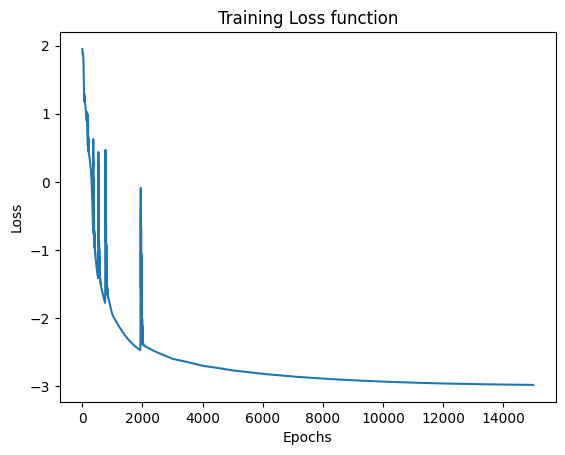

In [56]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()
x = range(0, len(training_loss))
y = np.log10(training_loss)
plt.plot(x, y)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss.png')

In [45]:
## EVALUATION MODE- from pretrained model
PATH = "model_PODNN.pth"
lr = 0.01
[net, mse_cost_function, optimizer] = Initialize_model(seed_num, lr)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [57]:
#we compute the solution
x_test = [[.8, .4]] #they are different parameters from that chosen for the POD !
u_proj = predict_PODNN(x_test, net)

In [69]:
u_proj.shape

(713,)

### Errors and speed-up of PINN w.r.t FOM

In [58]:
def compute_time_PODNN(x_test, net):
    tot_time = np.zeros(100)
    for i in range(100):
        start = time.time()
        u_proj = predict_PODNN(x_test, net)
        predict_time = time.time() - start
        tot_time[i] = predict_time
    mean_time = np.mean(tot_time)
    print(f'Mean PODNN prediction time:')
    print(mean_time)
    return mean_time

In [59]:
def compute_error_PODNN_FOM(u_proj,u, u_strong):
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_proj, u_strong, lib)
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol_fom, sol_x_fom, sol_y_fom] = gedim.EvaluateSolutionOnPoints(u, u_strong, lib)
    
    error_L2_PODNN = np.float64(0)
    error_H1_PODNN = np.float64(0)
    norm_L2_fom = 0
    norm_H1_fom = 0

    for q in range(numQuadraturePoints):
        
        error_L2_PODNN += quadratureWeights[q] * np.square(sol_fom[q] - sol[q])
        error_H1_PODNN += quadratureWeights[q] * (np.square(sol_x_fom[q] - sol_x[q]) + np.square(sol_y_fom[q] - sol_y[q]))
        
        norm_L2_fom += quadratureWeights[q] * (np.square(sol_fom[q]))
        norm_H1_fom += quadratureWeights[q] * (np.square(sol_x_fom[q]) + np.square(sol_y_fom[q]))
        
    return np.sqrt(error_L2_PODNN), np.sqrt(error_H1_PODNN), np.sqrt(norm_L2_fom), np.sqrt(norm_H1_fom), sol, numQuadraturePoints, quadraturePoints

In [60]:
import time

abs_err_L2 = []
rel_err_L2 = []
abs_err_H1 = []
rel_err_H1 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(10, P.shape[0]))
speed_up = []

u_strong = np.zeros(problemData['NumberStrongs'], order='F')

for mu in testing_set:
    [u, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=False)

    x_test = [mu]

    mean_time_PODNN = compute_time_PODNN(x_test, net)
    
    speed_up.append(sum(time_FOM+time_assembling_FOM)/mean_time_PODNN)

    u_proj = predict_PODNN(x_test, net)

    [error_L2_PODNN_FOM, error_H1_PODNN_FOM, norm_L2_fom, norm_H1_fom, sol, numQuadraturePoints, quadraturePoints] = compute_error_PODNN_FOM(u_proj, u, u_strong)
    abs_err_L2.append(error_L2_PODNN_FOM)
    abs_err_H1.append(error_H1_PODNN_FOM)
    
    rel_err_L2.append(error_L2_PODNN_FOM/sol_norm_L2)
    rel_err_H1.append(error_H1_PODNN_FOM/sol_norm_H1)

Params: [0.11806407799995373, 0.3898712490248605]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 7.7842029673687925e-04 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 5.7146554142311138e-10 3 20
Mean PODNN prediction time:
0.0003044891357421875
Params: [0.2903032062968902, 0.39474761696012317]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.9158564016670261e-03 2 20
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 8.5267035827879553e-09 3 20
Mean PODNN prediction time:
0.00020741939544677735
Params: [0.2077859186373261, 0.9014745526659055]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
713 6.4341029499729044e-02 1.0000000000000000e+00 1 20
dofs h residual 

In [61]:
print("average relative error in L2 = ", np.mean(rel_err_L2) ) # we have something around 10^-2, while above was 10^-4. We don't had finished the training phase BUT the POD is ALWAYS more accurate then the PODNN
print("average absolute error in L2 = ", np.mean(abs_err_L2) )

print("average relative error in H1 = ", np.mean(rel_err_H1) ) # we have something around 10^-2, while above was 10^-4. We don't had finished the training phase BUT the POD is ALWAYS more accurate then the PODNN
print("average absolute error in H1 = ", np.mean(abs_err_H1) )
print("average speed_up wrt FOM = ", np.mean(speed_up) ) # we gain an order of speed up. For non linear problems it is very important to employ the speed up, although the Galerkin give a better approximation

average relative error in L2 =  0.003173490422279252
average absolute error in L2 =  0.0016408364415941307
average relative error in H1 =  0.0031809211974109476
average absolute error in H1 =  0.014589086010417798
average speed_up wrt FOM =  2930.135040737831


In [226]:
with open("speed_up_PODNN_quadform.txt", "w") as file:
    file.write(f"{np.mean(rel_err_L2)},{np.mean(abs_err_L2)},{np.mean(rel_err_H1)}, {np.mean(abs_err_H1)}, {np.mean(speed_up)}")

df = pd.DataFrame({'Error_rel_L2_FOM_ROM': [np.mean(rel_err_L2)],'Error_abs_L2_FOM_ROM': [np.mean(abs_err_L2)],'Error_rel_H1_FOM_ROM': [np.mean(rel_err_H1)], 'Error_abs_H1_FOM_ROM': [np.mean(abs_err_H1)], 'Speed_up_POD': [np.mean(speed_up)]})
df.to_csv("speed_up_PODNN_quadform.csv")

### Plot

In [51]:
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

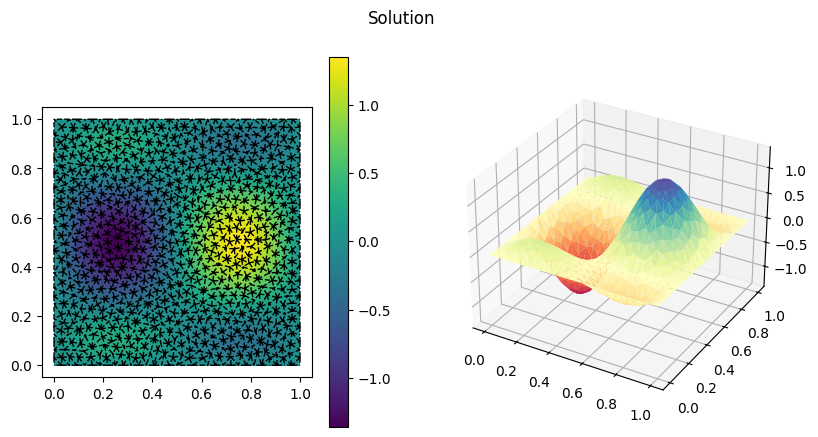

In [62]:
#Visualizzazione della soluzione e calcolo dell'errore FONDAMENTALI NEL PROGETTO !!!
gedim.PlotSolution(mesh, dofs, strongs, u_proj, u_strong)

#PLotSolution implements in Pyton the two plot of 2D and 3D plots of the solution. IT's better to export the solution in order to visulize the solution in other applications, as ParaView
#ExportSolution give us a file .inp which is the file format of the UCD structur file. It's limitated to specific type of geometrical elemntsù: tringle hexahedron, thetraedron, pyramidon, line, points.
# Filter "Warp by scalar" in ParaView let choos one of the scalar associated to the solution... to 3D visualization

gedim.ExportSolution(Test_exactSolution, u_proj, u_strong, lib)